In [114]:
%pip install --upgrade DBcm

Note: you may need to restart the kernel to use updated packages.


In [115]:
import DBcm

In [116]:
credentials = {
    "host": "localhost",
    "database": "BlackjackDB",
    "user": "richard",
    "password": "richpassword"
}

In [117]:
import random

In [118]:
users = ("Reacu","JosherFella","Rooblan","BarPaul","Coor")

In [119]:
def get_numbered_user_data_from_table(user, data, table):
        with DBcm.UseDatabase(credentials) as database:
            SQL = f"""
                select count(*) from {table}
                where user = '{user}' and outcomes = '{data}'
            """
            database.execute(SQL)
            results = database.fetchone()
            return results[0]

In [120]:
def get_detailed_user_data_from_table(user, data, table):
        with DBcm.UseDatabase(credentials) as database:
            SQL = f"""
                select {data} from {table}
                where user = '{user}'
            """
            database.execute(SQL)
            results = database.fetchone()
            return results[0]

In [121]:
def get_highest_win_streak(user):
        with DBcm.UseDatabase(credentials) as database:
            SQL = """
                select * from user_game_statistics 
                where user = %s
            """
            database.execute(SQL,(user,))
            results = database.fetchall()

        highest_win_streak = 0
        current_streak_count = 0

        for result in results:
            if result[1] == "Win":
                current_streak_count += 1
            if result[1] != "Win":
                if current_streak_count > highest_win_streak: 
                    highest_win_streak = current_streak_count
                current_streak_count = 0 
        
        return highest_win_streak

In [122]:
def update_database(user):
    with DBcm.UseDatabase(credentials) as database:

        SQL = """
            update user_statistics
            set win_rate = %s,
                bust_rate = %s,
                highest_win_streak = %s
            where user = %s
        """

        wins = get_numbered_user_data_from_table(user, "Win", "user_game_statistics")
        losses = get_numbered_user_data_from_table(user, "Loss", "user_game_statistics")
        busts = get_numbered_user_data_from_table(user, "Bust", "user_game_statistics")
        draws = get_numbered_user_data_from_table(user, "Draw", "user_game_statistics")

        total_games = wins + losses + busts + draws
        win_rate = wins / total_games
        bust_rate = busts / total_games
        highest_win_streak = get_highest_win_streak(user)

        database.execute(SQL,(win_rate,bust_rate,highest_win_streak,user,))

In [123]:
def check_valid_user(user):
        with DBcm.UseDatabase(credentials) as database:
            SQL = """
                select distinct user from user_statistics 
                where user = %s
            """
            database.execute(SQL, (user,))
            returned_user = database.fetchone()

            # If the user doesn't exist, insert a default record
            if returned_user == None:
                default_insert_SQL = """
                    insert into user_statistics (user, win_rate, bust_rate, highest_win_streak)
                    values (%s, 0, 0, 0)
                """
                database.execute(default_insert_SQL, (user,))

In [124]:
scores = {}
busts = {}
highest_win_streaks = {}

In [125]:
#Clears data
 
for user in users:
    with DBcm.UseDatabase(credentials) as db:
        SQL = "DELETE FROM user_statistics WHERE user = %s"
        db.execute(SQL, (user,))
        SQL = "DELETE FROM user_game_statistics WHERE user = %s"
        db.execute(SQL, (user,))
        print(f"Data for user {user} cleared from user_game_statistics table.")


Data for user Reacu cleared from user_game_statistics table.
Data for user JosherFella cleared from user_game_statistics table.
Data for user Rooblan cleared from user_game_statistics table.
Data for user BarPaul cleared from user_game_statistics table.
Data for user Coor cleared from user_game_statistics table.


In [126]:
##Populate database with Data
users = ("Reacu","JosherFella","Rooblan","BarPaul","Coor")
outcomes = ["Win","Loss","Bust","Draw"]
outcome_weights = [0.35,0.35,0.1,0.05]


for user in users:
    #Insert raw data
    for _ in range(100):
        check_valid_user(user)

        outcome = random.choices(outcomes, weights=outcome_weights)[0]

        with DBcm.UseDatabase(credentials) as database:
            SQL = """ 
                insert into user_game_statistics
                (user, outcomes)
                values
                (%s , %s)
            """
            database.execute(SQL,(user,outcome,))

        update_database(user)

In [127]:
for user in users:
    scores[user] = get_detailed_user_data_from_table(user, "win_rate","user_statistics")
    busts[user] = get_detailed_user_data_from_table(user, "bust_rate", "user_statistics")
    highest_win_streaks[user] = get_highest_win_streak(user)

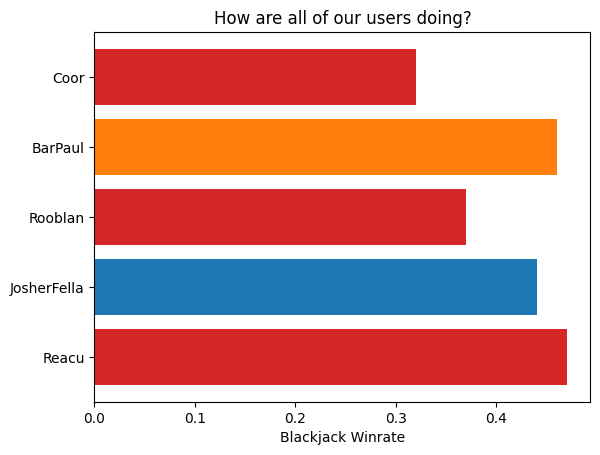

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y_labels = list(scores.keys())
x_values = list(scores.values())


bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.barh(y_labels, x_values, color=bar_colors)


ax.set_xlabel('Blackjack Winrate')
ax.set_title('How are all of our users doing?')

plt.show()

Text(0.5, 1.0, 'The highest win streaks of our users')

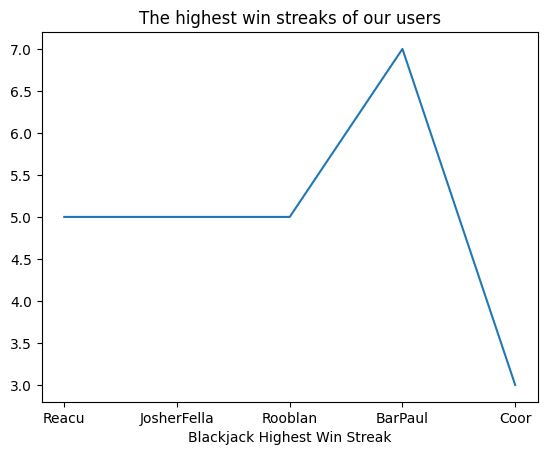

In [129]:
import matplotlib.pyplot as plt

y_labels = list(highest_win_streaks.keys())
x_values = list(highest_win_streaks.values())

fig, axs = plt.subplots()
axs.plot(y_labels, x_values)

axs.set_xlabel('Blackjack Highest Win Streak')
axs.set_title('The highest win streaks of our users')

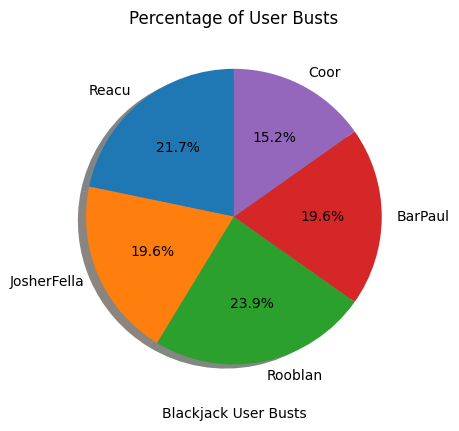

In [130]:
import matplotlib.pyplot as plt

labels = busts.keys()
win_streaks = busts.values()

fig, ax = plt.subplots()

#explode highestr streak later
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
#ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       #shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)

ax.pie(win_streaks, labels=labels, autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)

ax.set_xlabel('Blackjack User Busts')
ax.set_title('Percentage of User Busts')

plt.show()